# 💬 Agente de Perguntas e Respostas com RAG — SegurosLLM
---

Um assistente interno de conhecimento para colaboradores da **SegurosLLM**, baseado em **Retrieval-Augmented Generation (RAG)**.  
Combina **busca semântica** com **modelos GPT da OpenAI**, oferecendo respostas rápidas, precisas e econômicas sobre políticas, processos e documentos internos.

---

### 🚀 Visão Geral
- **Objetivo:** Responder perguntas sobre a SegurosLLM usando uma arquitetura RAG simples.  
- **Modelos:** GPT da OpenAI via LangChain.  
- **Recuperação:** ChromaDB com embeddings da OpenAI.  
- **Interface:** Chat interativo via Gradio.

---

### 🧩 Principais Recursos
- 📂 Carrega automaticamente arquivos **PDF**, **TXT** e **Markdown** de subpastas.  
- ⚡ Atualiza apenas quando há mudanças nos arquivos (evita retrabalho).  
- 🧠 Divide documentos em partes sobrepostas para melhorar a precisão da busca.  
- 🔍 Recupera informações relevantes por similaridade semântica.  
- 🗣️ Mantém histórico de conversa e exibe as fontes usadas nas respostas.  
- 🧾 Garante respostas baseadas apenas na base de conhecimento interna.  
- 🎨 Interface web leve e intuitiva, com respostas em tempo real.  
- 🛡️ Lida com erros e detecta conteúdo duplicado de forma automática.  
- 🧰 Estrutura pronta para uso corporativo, com organização de documentos e logs.  

---

### ⚙️ Configuração

- **LangChain:** 0.3.21  
- **OpenAI:** 1.69.0  
- **ChromaDB:** 0.6.3  
- **Gradio:** 5.23.1  
- **Python:** 3.11.11  

### 🛠️ Requisitos
🔑 Chave de API da OpenAI (`OPENAI_API_KEY`)  
💻 Hardware: CPU é suficiente — GPU não necessária.

---

### 🧩 Personalização
- 📝 Ajuste os prompts do sistema e de contexto.  
- 📁 Adicione novos documentos corporativos.  
- 🎯 Modifique parâmetros como **top-k** (número de resultados relevantes) e limiar de similaridade.

---

## 📥 Importações

Este bloco importa todas as ferramentas que o projeto precisa para funcionar.
- As primeiras são do próprio Python (como os, hashlib e pathlib) e ajudam a lidar com arquivos e pastas.
- Depois vêm as bibliotecas externas, como numpy (para cálculos), plotly (para gráficos) e gradio (para criar interfaces).
- Por fim, entram as ferramentas do LangChain, que ajudam o projeto a conversar com a IA, entender textos e organizar informações.

In [1]:
# Importação: bibliotecas padrão
import os
import hashlib
from pathlib import Path
from typing import List

# Importação: bibliotecas de terceiros
import numpy as np
import plotly.graph_objects as go
from dotenv import load_dotenv
from pydantic import Field
from sklearn.manifold import TSNE
import gradio as gr

# Integrações principais do LangChain
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import BaseRetriever, Document
from langchain.schema.vectorstore import VectorStoreRetriever
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate

# Integrações do LangChain
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma

print("✅ Sucesso, Importações!")

✅ Sucesso, Importações!


## 🔐 Carregar variáveis de ambiente e configurações

Aqui o código prepara o ambiente:
- Ele carrega informações secretas do arquivo .env (como a chave da OpenAI).
- Define onde estão os arquivos de texto e onde ficará o banco de dados vetorial.
- E verifica se a chave da OpenAI foi encontrada — sem ela, o projeto não consegue conversar com a IA.

In [2]:
# Carregar variáveis de ambiente
load_dotenv(override=True)

# Configuração
DATA_PATH = "demo-rag/base-conhecimento/"  
MODEL = "gpt-4o-mini"
CHROMA_PATH = "vector_db/chroma_segurosllm"

# Acessar explicitamente a chave da API da OpenAI
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    print("❌ OPENAI_API_KEY não encontrada")
else:
    print("✅ OPENAI_API_KEY carregada com sucesso!")

✅ OPENAI_API_KEY carregada com sucesso!


## 📄 Carregar arquivos como objetos Document na memória
Este bloco lê todos os arquivos da pasta base-conhecimento (e suas subpastas).
- Ele entende se o arquivo é .pdf, .txt ou .md e escolhe a melhor forma de abri-lo.
- Cada documento recebe uma “etiqueta” dizendo de qual pasta e arquivo veio.
- No fim, mostra quantos documentos foram carregados e de qual tipo — como “empresa”, “contrato”, “produtos” etc.
- Assim o sistema sabe de onde veio cada pedaço de informação que usará para responder perguntas.

In [3]:
from pathlib import Path
from langchain.document_loaders import PyPDFLoader, TextLoader

# Caminho base
DATA_PATH = Path("./base-conhecimento")

# Lista principal de documentos
documents = []

def add_metadata(doc, file_path):
    """
    Adiciona metadados de tipo (nome da subpasta) e nome do arquivo.
    """
    doc.metadata["doc_type"] = file_path.parent.name   # Ex: empresa, contrato, funcionarios, produtos
    doc.metadata["file_name"] = file_path.name
    if not doc.page_content.strip():
        print(f"⚠️ Conteúdo vazio em {file_path}")
    return doc

# Loop para percorrer todos os arquivos nas subpastas
for file_path in DATA_PATH.rglob("*"):
    # Ignorar checkpoints do Jupyter
    if ".ipynb_checkpoints" in file_path.parts:
        continue

    # Ignorar diretórios
    if file_path.is_dir():
        continue

    # Identificar o tipo de arquivo e carregar com o loader correto
    try:
        if file_path.suffix.lower() == ".pdf":
            loader = PyPDFLoader(str(file_path))
        elif file_path.suffix.lower() in (".txt", ".md"):
            loader = TextLoader(str(file_path), encoding="utf-8")
        else:
            # Ignorar extensões que não sejam .pdf, .txt ou .md
            continue

        docs = loader.load()
        documents.extend([add_metadata(doc, file_path) for doc in docs])

    except Exception as e:
        print(f"❌ Erro ao carregar {file_path}: {e}")
        continue

# Resumo final
if documents:
    tipos = {}
    for doc in documents:
        tipo = doc.metadata.get("doc_type", "desconhecido")
        tipos[tipo] = tipos.get(tipo, 0) + 1

    print(f"\n✅ {len(documents)} documentos carregados com sucesso!\n")
    print("📂 Distribuição por categoria:")
    for tipo, qtd in tipos.items():
        print(f"   - {tipo}: {qtd} documentos")
else:
    print("Nenhum documento carregado.")


✅ 26 documentos carregados com sucesso!

📂 Distribuição por categoria:
   - funcionarios: 12 documentos
   - empresa: 3 documentos
   - contratos: 7 documentos
   - produtos: 4 documentos


## ✂️ Dividindo documentos em pedaços (fragmentos)
Aqui o código corta os documentos grandes em pedaços menores (fragmentos).
- Isso ajuda a IA a entender o conteúdo sem se perder em textos longos.
- Cada fragmento recebe um “identificador único”, como se fosse um RG, gerado a partir do seu conteúdo.
- Assim, o sistema pode identificar e rastrear cada pedaço de texto depois.

In [4]:
import hashlib
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    chunk_size=1000,          # tamanho de cada fragmento em caracteres
    chunk_overlap=200,        # sobreposição entre fragmentos para manter contexto
    add_start_index=True      # mantém a ordem (útil para rastrear contexto)
)

# Gerar fragmentos
fragmentos = text_splitter.split_documents(documents)

print(f"{len(documents)} documentos divididos em {len(fragmentos)} fragmentos.")

# 🧠 Gerar identificador único (hash) para cada fragmento
def gerar_id_fragmento(texto):
    """Cria um ID único (MD5) com base no conteúdo do fragmento."""
    return hashlib.md5(texto.encode("utf-8")).hexdigest()

for fragmento in fragmentos:
    fragmento.metadata["fragmento_id"] = gerar_id_fragmento(fragmento.page_content)
    if not fragmento.page_content.strip():
        print(f"⚠️ Fragmento vazio em: {fragmento.metadata['file_name']}")

# 🧩 Exibir exemplo de metadados
for i, fragmento in enumerate(fragmentos[:2]):
    print(f"\nMetadados do fragmento {i+1}:")
    print(fragmento.metadata)

26 documentos divididos em 106 fragmentos.

Metadados do fragmento 1:
{'source': 'base-conhecimento/funcionarios/Alex Chen.md', 'doc_type': 'funcionarios', 'file_name': 'Alex Chen.md', 'start_index': 0, 'fragmento_id': 'f10f9473cf9181899a192a66d8916160'}

Metadados do fragmento 2:
{'source': 'base-conhecimento/funcionarios/Alex Chen.md', 'doc_type': 'funcionarios', 'file_name': 'Alex Chen.md', 'start_index': 986, 'fragmento_id': 'b10faf77382b919d34f21c9a6cfd1d5b'}


In [6]:
fragmento_ids = [fragmento.metadata["fragmento_id"] for fragmento in fragmentos]
ids_duplicados = [fid for fid in fragmento_ids if fragmento_ids.count(fid) > 1]

if ids_duplicados:
    print(f"⚠️ IDs de fragmentos duplicados encontrados: {ids_duplicados}")
else:
    print("✅ Nenhum fragmento duplicado encontrado.")

✅ Nenhum fragmento duplicado encontrado.


## 🧠 Embeddings dos Fragmentos

- Aqui o código cria uma “ferramenta de tradução” que transforma os textos em números (vetores).
- Esses vetores são a forma como a IA entende o significado dos textos, permitindo comparar e buscar informações parecidas.

In [7]:
from langchain_openai import OpenAIEmbeddings

# Criar função de embedding (por padrão usa o modelo multilíngue text-embedding-ada-002)
embedding_function = OpenAIEmbeddings()

print("✅ Função de embeddings criada com sucesso.")

✅ Função de embeddings criada com sucesso.


## 💾 Salvar fragmentos com embeddings no banco de dados Chroma

- Este bloco cria (ou atualiza) um banco de dados especial chamado Chroma DB.
- Nesse banco, cada fragmento é guardado com seu significado (vetor).
- Antes de recriar tudo, o código confere se já existe um banco igual — assim economiza tempo e processamento.

In [10]:
import os
from langchain_chroma import Chroma

# Criar diretório do Chroma se não existir
os.makedirs(CHROMA_PATH, exist_ok=True)

def obter_ids_fragmentos_existentes(db_path):
    """Carrega os IDs dos fragmentos já armazenados no Chroma DB."""
    try:
        db_existente = Chroma(persist_directory=db_path)
        resultados = db_existente._collection.get(include=["metadatas"])
        return set(
            m["fragmento_id"] for m in resultados["metadatas"]
            if isinstance(m, dict) and "fragmento_id" in m
        )
    except Exception as e:
        print("❌ Erro ao carregar IDs de fragmentos existentes:", e)
        return set()

# Obter IDs dos fragmentos atuais
novos_ids_fragmentos = set([f.metadata["fragmento_id"] for f in fragmentos])

# Obter IDs de fragmentos existentes no Chroma
fragmentos_existentes_ids = obter_ids_fragmentos_existentes(CHROMA_PATH)

# Comparar e atualizar
if novos_ids_fragmentos != fragmentos_existentes_ids:
    print("🧩 Mudanças nos fragmentos detectadas. Reconstruindo Chroma DB...")
    db = Chroma.from_documents(
        documents=fragmentos,
        embedding=embedding_function,
        persist_directory=CHROMA_PATH
    )
    print(f"✅ {len(fragmentos)} fragmentos salvos em {CHROMA_PATH}.")
else:
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)
    print("✅ Chroma DB está atualizado. Pulando regeneração.")

✅ Chroma DB está atualizado. Pulando regeneração.


## 📊 Visualizando o Vector Store

- Este bloco pega os dados guardados no banco e organiza para fazer gráficos.
- Cada ponto representa um pedaço de texto (fragmento) e a cor mostra o tipo de documento de onde veio — por exemplo, contratos, produtos, etc.

In [13]:
import numpy as np

collection = db._collection
result = collection.get(include=['embeddings', 'documents', 'metadatas'])

# Extrair embeddings, documentos e metadados
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']


# Lista de cores e mapeamento por tipo
color_map = {
    "produtos": "blue",
    "funcionarios": "yellow",
    "contratos": "red",
    "empresa": "cyan"
}

# Extrair o tipo de documento de forma segura
doc_types = [meta.get("doc_type", "unknown") for meta in metadatas]

# Definir cor (default = cinza se tipo não for reconhecido)
colors = [color_map.get(t, "gray") for t in doc_types]

print(f"✅ Extraídos {len(documents)} documentos e {len(vectors)} embeddings do Chroma DB.")

✅ Extraídos 106 documentos e 106 embeddings do Chroma DB.


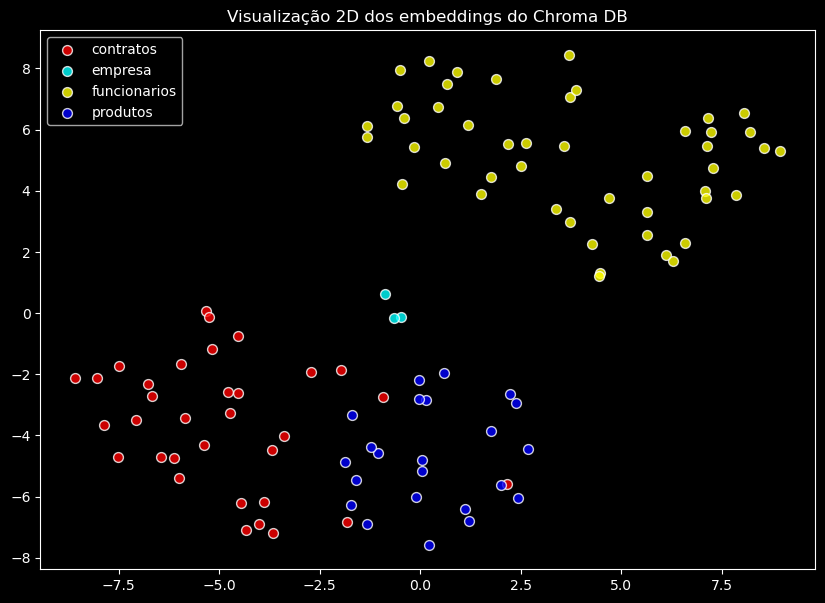

In [14]:
# Nós, humanos, achamos mais fácil visualizar coisas em 2D!
# Reduzir a dimensionalidade dos vetores para 2D usando t-SNE
# (t-distributed stochastic neighbor embedding)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduzir dimensões para 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Plotar
plt.style.use('dark_background')  # fundo preto

plt.figure(figsize=(10, 7))
for t in set(doc_types):
    idx = [i for i, dt in enumerate(doc_types) if dt == t]
    plt.scatter(vectors_2d[idx, 0], vectors_2d[idx, 1], 
                label=t, 
                c=color_map.get(t, "gray"), 
                alpha=0.8, 
                s=50,
                edgecolors='w')  # borda branca para destacar pontos

plt.title("Visualização 2D dos embeddings do Chroma DB", color='white')
plt.legend()
plt.show()

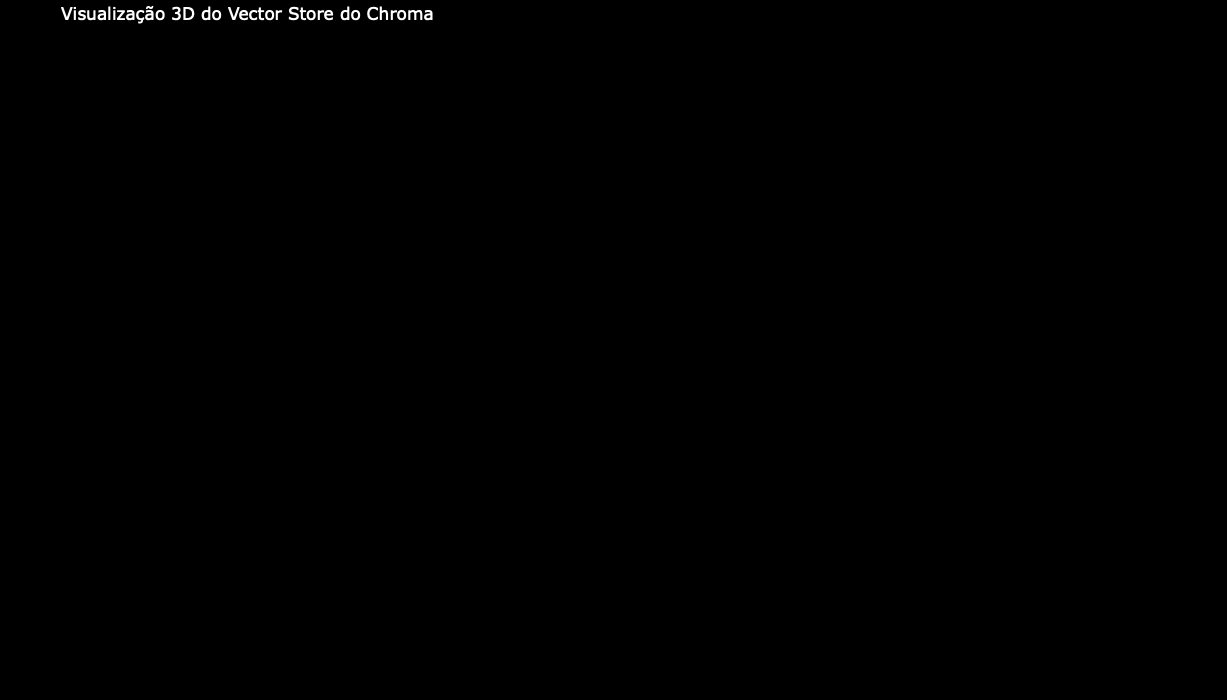

In [15]:
# Vamos tentar 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Criar o gráfico de dispersão 3D
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Tipo: {t}<br>Texto: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='Visualização 3D do Vector Store do Chroma',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    scene=dict(
        xaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        yaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        zaxis=dict(color='white', backgroundcolor='black', showbackground=True)
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## 🔍 Consultar (query) Chroma

- Este código cria um “buscador inteligente” (retriever).
- Ele procura nos textos apenas os trechos que realmente têm a ver com a pergunta feita.
- Cada trecho é avaliado por uma pontuação de relevância — quanto maior, mais parecido com a pergunta.
- Além disso, o código adiciona a fonte do texto para sabermos de onde veio a informação.

In [16]:
from langchain.schema import Document
from langchain.vectorstores import Chroma
from typing import List

similarity_threshold = 0.5  # Ajuste conforme necessário
k_results = 20              # Quantos documentos retornar

# Classe customizada para filtrar por score
class MyChromaRetriever:
    def __init__(self, vectorstore: Chroma, k: int = 20, threshold: float = 0.2):
        self.vectorstore = vectorstore
        self.k = k
        self.threshold = threshold

    def get_relevant_documents(self, query: str) -> List[Document]:
        results = self.vectorstore.similarity_search_with_relevance_scores(query, k=self.k)
        filtered_docs = []
        for doc, score in results:
            doc.metadata["score"] = score
            if score >= self.threshold:
                filtered_docs.append(doc)

        # Debug: imprimir scores dos primeiros 5 documentos
        print("\n📄 Scores dos documentos retornados (top 5):")
        for doc in filtered_docs[:5]:
            print(f"- {doc.metadata.get('file_name','Desconhecido')}: {doc.metadata['score']:.4f}")

        return filtered_docs

# Função para injetar metadados no conteúdo
def inject_metadata(doc: Document) -> Document:
    doc_type = doc.metadata.get("doc_type", "Desconhecido")
    file_name = doc.metadata.get("file_name", "Desconhecido")
    content = f"\n#======================================\n[FONTE: {doc_type} - {file_name}]\n{doc.page_content}"
    return Document(page_content=content, metadata=doc.metadata)

# Retriever que injeta metadados
class MetadataInjectingRetriever:
    def __init__(self, base_retriever: MyChromaRetriever):
        self.base_retriever = base_retriever

    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = self.base_retriever.get_relevant_documents(query)
        return [inject_metadata(doc) for doc in docs]

# Configurar retriever
retriever_base = MyChromaRetriever(vectorstore=db, k=k_results, threshold=similarity_threshold)
retriever = MetadataInjectingRetriever(base_retriever=retriever_base)

docs = retriever.get_relevant_documents("Maiores salários 2023")
docs = retriever.get_relevant_documents("Maior idade")
#for d in docs:
#    print(d.page_content)

#print("✅ Retriever configurado e pronto para consultas!")


📄 Scores dos documentos retornados (top 5):
- Emily Carter.md: 0.7963
- Samuel Trenton.md: 0.7816
- Avery Lancaster.md: 0.7725
- Alex Harper.md: 0.7720
- Jordan K. Bishop.md: 0.7654

📄 Scores dos documentos retornados (top 5):
- Jordan K. Bishop.md: 0.6962
- Samuel Trenton.md: 0.6956
- Maxine Thompson.md: 0.6950
- Alex Chen.md: 0.6944
- Maxine Thompson.md: 0.6940


## 🗣️ LLM e respostas

#### Parte 1
- Aqui o modelo de IA (ChatGPT) é inicializado.
- Ele também ganha uma “memória”, que guarda o histórico da conversa, para lembrar o que já foi falado antes.
- Isso permite respostas mais naturais e coerentes ao longo do diálogo.

#### Parte 2
- Este bloco junta tudo: o modelo de IA, a memória e o buscador.
- Ele cria uma “cadeia de conversação”, que é a parte do sistema que realmente entende as perguntas e busca as respostas nos documentos.
- No final, o código faz uma pergunta de teste e mostra a resposta da IA.

In [ ]:
# Parte 1: Inicialização do LLM e memória (versão compatível com o novo LangChain)

from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.memory.chat_message_histories import ChatMessageHistory

# Modelo a ser usado
MODEL = "gpt-3.5-turbo"

# Inicializar LLM
llm = ChatOpenAI(temperature=0.7, model=MODEL)

# Criar histórico moderno
chat_history = ChatMessageHistory()

# Criar memória moderna da conversa
memory = ConversationBufferMemory(
    memory_key="chat_history",
    chat_memory=chat_history,  # ✅ novo parâmetro exigido
    return_messages=True,
    output_key="answer"
)

print("✅ LLM e memória configurados com LangChain!")

In [ ]:
# Parte 2: ConversationalRetrievalChain atualizada

from langchain.prompts import PromptTemplate
from langchain.chains import ConversationalRetrievalChain

# --- Configurações ---
similarity_threshold = 0.5
k_results = 20

# Criar o prompt do sistema
system_prompt = """
Você é um assistente que responde perguntas sobre a empresa SegurosLLM.

Use o histórico de conversa e os documentos recuperados para responder.

Sempre baseie suas respostas estritamente nos documentos recuperados. Se os documentos contiverem informações parciais, responda com o que estiver disponível. Se não houver informação, diga isso.

Não invente nomes, cargos ou fatos.

Você pode usar as informações da fonte do documento mostradas no formato [FONTE: doc_type - file_name] se isso ajudar a responder a pergunta com precisão.

Sempre extraia números exatos (como número de funcionários, anos, receita, etc.) dos documentos, se mencionados.

Histórico de conversa:
{chat_history}

Documentos:
{context}

Pergunta:
{question}
"""

prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

# --- Criar retriever do Chroma ---
retriever = db.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": k_results, "score_threshold": similarity_threshold}
)

# --- Criar ConversationalRetrievalChain ---
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    combine_docs_chain_kwargs={"prompt": prompt},
    return_source_documents=False  # evita conflito com memória
)

# --- Pergunta de teste ---
question = "Quem são os 3 maiores salários em 2023 com base, bônus e total. Incluir nomes."

# Executar consulta
response = conversation_chain.invoke({"question": question})

print("\n🧠 Resposta:", response["answer"])

## 🎛️ Interface Gradio

- Aqui o código define as regras de comportamento do assistente.
- Ele explica como responder, quando ser cordial, e como lidar com dúvidas ou agradecimentos.
- É como ensinar boas maneiras e limites à IA antes de colocá-la para conversar.

from langchain.prompts import PromptTemplate

# --- Prompt do sistema atualizado ---
system_prompt = """
Você é um assistente que responde perguntas sobre a empresa SegurosLLM.

Use o histórico de conversa e os documentos recuperados para responder. Sempre baseie suas respostas estritamente nos documentos recuperados. Se os documentos contiverem informações parciais, responda com o que estiver disponível. Se não houver informação, diga isso.

Você pode usar as informações da fonte do documento no formato [FONTE: doc_type - file_name] se isso ajudar a responder a pergunta com precisão.

Extraia números exatos (como número de funcionários, anos, receita, etc.) dos documentos, se mencionados. Não invente nomes, cargos ou fatos.

Diretrizes de comportamento:
- Responda apenas quando o usuário fizer uma pergunta ou solicitar esclarecimento.
- Se o usuário cumprimentar ou agradecer, responda de forma cordial, mas **evite repetir a resposta anterior** a menos que solicitado explicitamente por mais detalhes.
- Se o usuário disser "obrigado" ou similar, reconheça com gratidão, mas **não forneça a mesma resposta novamente** a menos que informações adicionais sejam solicitadas.
- Se o usuário compartilhar feedback, reconheça, agradeça e ofereça assistência adicional.
- Se o usuário expressar frustração ou confusão, demonstre empatia, esclareça e ofereça suporte adicional.
- Se o usuário não encontrar uma resposta clara, incentive-o a pedir esclarecimentos ou fornecer mais detalhes, e ofereça assistência adicional.

Histórico de conversa:
{chat_history}

Documentos:
{context}

Pergunta:
{question}
"""

# --- Criar PromptTemplate ---
prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

print("✅ Prompt do sistema atualizado e pronto para uso!")

In [ ]:
from langchain.prompts import PromptTemplate

# --- Criar o template do prompt ---
prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

print("✅ PromptTemplate criado e pronto para uso!")

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

# --- Inicializar LLM ---
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# --- Memória de conversa ---
memory = ConversationBufferMemory(
    memory_key='chat_history',
    return_messages=True,
    output_key='answer'
)

# --- ConversationalRetrievalChain ---
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    combine_docs_chain_kwargs={"prompt": prompt}
)

# --- Função simples para chat ---
def chat(question):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

# --- Teste ---
resposta = chat("Quem são os 3 maiores salários em 2023 com base, bônus e total. Incluir nomes.")
print("\n🧠 Resposta:", resposta)

In [ ]:
import gradio as gr

# Função para Gradio no novo formato 'messages'
def chat_gradio(user_input, chat_history):
    resposta = chat(user_input)
    chat_history = chat_history or []
    chat_history.append({"role": "user", "content": user_input})
    chat_history.append({"role": "assistant", "content": resposta})
    # Retorna o histórico atualizado e limpa o textbox
    return chat_history, gr.update(value="")

# Criar interface com formato atualizado
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(type="messages")
    msg = gr.Textbox(placeholder="Digite sua pergunta aqui...")

    # O terceiro argumento da função submit indica o que será atualizado
    msg.submit(chat_gradio, [msg, chatbot], [chatbot, msg])

demo.launch(inbrowser=True)